# Graph processing using GraphFrames

In this notebook you will construct a graph from answers and users datasets and use GraphFrames library to run some algorithms on it.

In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, count, greatest, least

import os
from IPython.display import Image

In [29]:
spark = (
    SparkSession
    .builder
    .appName('Graph processing I')
    .config("spark.jars.packages", "graphframes:graphframes:0.8.0-spark3.0-s_2.12")
    .getOrCreate()
)

In [30]:
from graphframes import *

In [31]:
base_path = os.getcwd()

project_path = ('/').join(base_path.split('/')[0:-3]) 

answers_input_path = os.path.join(project_path, 'data/answers')

users_input_path = os.path.join(project_path, 'data/users')

image_path = os.path.join(project_path, 'data/images/graphframes.png')

# Task

Create a graph from users and answers. The users will be represented as nodes in the graph and two users will be connected by edge if they answered the same question (see the image bellow).

On the Graph run the following algorithms:
* [Label Propagation](https://en.wikipedia.org/wiki/Label_propagation_algorithm) to find some communities / clusters of users
* [PageRank](https://en.wikipedia.org/wiki/PageRank) to find important nodes in the graph 

Note
* consider taking only [sample](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.sample) of answers to reduce the size of the graph if you run in local mode
* also check the user guide for [GrahpFrames](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)

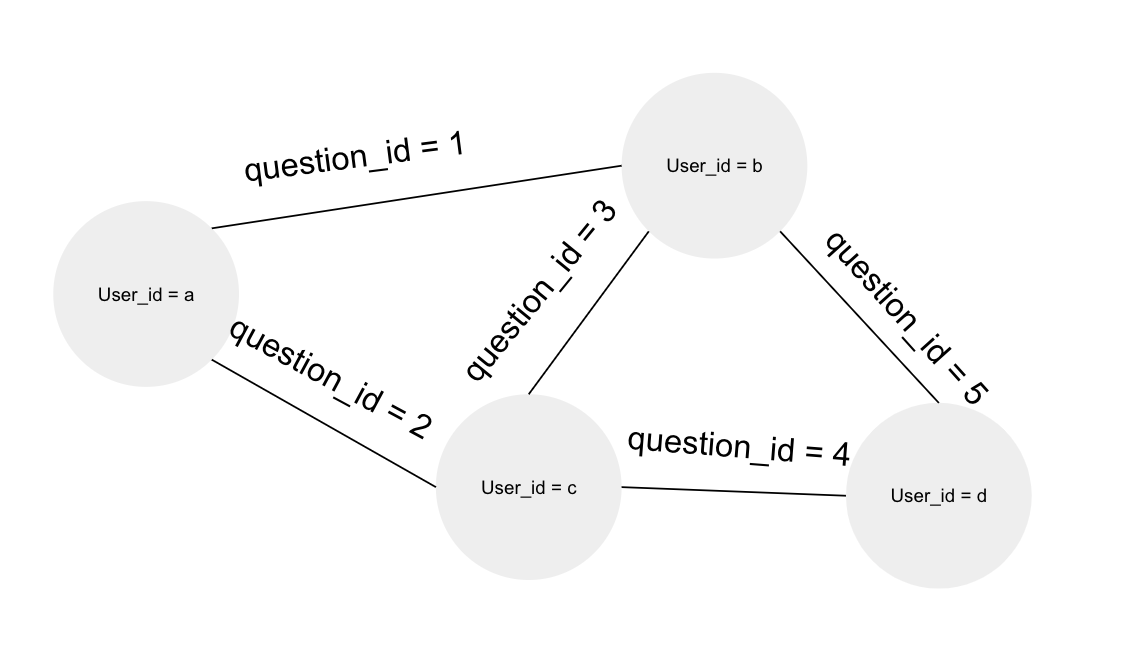

In [32]:
Image(image_path, width=480)

In [33]:
# answers is the main dataset used for the graph
answersDF = (
    spark
    .read
    .option('path', answers_input_path)
    .load()
).sample(0.1, False, 24).cache()

# we will also need users for metadata:
usersDF = (
    spark
    .read
    .option('path', users_input_path)
    .load()
).cache()

#### Create vertices:

Hint:
* select user_id
* deduplicate
* rename the col to id
* you may keep additional cols as metadata (joined from users)

In [34]:
verticesDF = (
    answersDF
    .filter(col('user_id').isNotNull())
    .select('user_id')
    .distinct()
    .join(usersDF, 'user_id')
    .select(
        col('user_id').alias('id'),
        col('display_name')
    )
)

#### Create edges:

Hint:
* do self-join of answers on `question_id` column
* filter out records where user_id from left side is the same as from right side
* rename `user_id` cols as `src` / `dst`

Example:
* when we do a self-join of the following data (one question answered by two users `a` and `b`):\
question_id  user_id \
1 &nbsp;&nbsp;&nbsp;&nbsp;a\
1 &nbsp;&nbsp;&nbsp;&nbsp;b
* we will get: \
a &nbsp;&nbsp; 1 &nbsp;&nbsp;a \
a &nbsp;&nbsp; 1 &nbsp;&nbsp;b \
b &nbsp;&nbsp; 1 &nbsp;&nbsp;a \
b &nbsp;&nbsp; 1 &nbsp;&nbsp;b
* we need to remove where the node is joined with itself, `a-1-a` and `b-1-b`
* we also need to remove the duplicated rows created by the join: `a-1-b` is the same as `b-1-a`
    * these functions will be helpful:
        * [greatest](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.greatest)
        * [least](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.least)

In [47]:
edgesDF = (
    answersDF.alias('src')
    .join(
        answersDF.alias('dst'),
        'question_id'
    )
    .withColumn('src', greatest(col('src.user_id'), col('dst.user_id')))
    .withColumn('dst', least(col('src.user_id'), col('dst.user_id')))
    .select('src', 'dst', 'question_id')
    .distinct() # remove the duplicities (a-1-b is the same as b-1-a, but a-2-b is different)
    .filter(col('src') != col('dst')) # remove nodes connected to itself (a-1-a)
)

#### Create the graph:

Hint:
* use GraphFrame(vertices, edges) 

In [37]:
usersGraph = GraphFrame(verticesDF, edgesDF)

#### See some properties of the graph:

Hint:
* count number of edges
* count number of vertices

In [38]:
edgesDF.count()

2900

In [39]:
verticesDF.count()

1765

#### Find frequent edges

Hint:
* group by edge (edge is defined by two cols: `src`, `dst`) and count how many times the edge is in the graph
* order by the count in descending order

In [40]:
(
    usersGraph
    .edges
    .groupBy('src', 'dst')
    .count()
    .orderBy(desc('count'))
).show(n=5)

+-------+-------+-----+
|    src|    dst|count|
+-------+-------+-----+
| 446303|  59793|    1|
| 777408| 490961|    1|
|7643022|5670873|    1|
|1896169| 571407|    1|
|4762892| 423497|    1|
+-------+-------+-----+
only showing top 5 rows



#### Find communities

Hint:
* use [labelPropagation](https://graphframes.github.io/graphframes/docs/_site/api/python/graphframes.html#graphframes.GraphFrame.labelPropagation)
* see how many users are in each community
 * group by `label` and count
* see what users are in a given community
 * filter on `label` col

In [41]:
communities = usersGraph.labelPropagation(5)

In [42]:
(
  communities
    .groupBy('label')
    .agg(count('*').alias('cnt'))
    .orderBy(desc('cnt'))
).show(n=5)

+--------+---+
|   label|cnt|
+--------+---+
|  412793|  2|
| 1518300|  2|
|  193189|  1|
|  597013|  1|
|  250917|  1|
|  130237|  1|
| 2105855|  1|
| 5750077|  1|
|11533945|  1|
|  512061|  1|
+--------+---+
only showing top 10 rows



In [43]:
(
  communities
  .filter(col("label") == 412793)
).show()

+------+------------+------+
|    id|display_name| label|
+------+------------+------+
|565224|      TauPan|412793|
|412793|      varela|412793|
+------+------------+------+



#### Compute PageRank

* use [pageRank](https://graphframes.github.io/graphframes/docs/_site/api/python/graphframes.html#graphframes.GraphFrame.pageRank) method
* order the vertices by pagerank

In [44]:
pr = (
   usersGraph.pageRank(tol=0.01)
 )

In [45]:
(
  pr
  .vertices
  .orderBy(desc('pagerank'))
).show()

+--------+------------------+------------------+
|      id|      display_name|          pagerank|
+--------+------------------+------------------+
|   61434|             uli78| 3.936615315891763|
|    8761|          AlanKley|2.9331479255018955|
|   47886|      Jeff Sternal|2.6567076900726594|
|  236222|               Jay| 2.521886992081032|
|  514749|            pimvdb|1.9531286851541874|
| 1216003|           vinothp|1.9531286851541874|
|   20400|      Omar Kooheji|1.9531286851541874|
| 1697527|         aLiEnHeAd|1.9070131467547131|
|   22039|           Cherian|1.9070131467547131|
| 2105986|            faizal|1.9070131467547131|
|  412793|            varela|1.9070131467547131|
|  140894|     Don O'Donnell|1.8608976083552393|
| 2150879|      Fiddle Freak|1.6456917624910279|
|    4916|        Scott Saad|1.5854853651361593|
|  447901|               lit|1.4099901217826059|
| 4069641|               L_M|1.3382548398278689|
| 4263025|            Cillín|1.3382548398278689|
|10823490|          

In [46]:
# spark.stop()